#Agentic MCP

In [ ]:
# !pip install pandas==2.2.2 requests==2.32.4 sentence-transformers langchain langchain-community langchain_google_genai faiss-cpu google-generativeai duckdb matplotlib langchain_experimental langchain-huggingface

import os
from google.colab import userdata
import pandas as pd
import duckdb
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# --- 1. SETUP API KEY AND DATA ---

os.environ["GOOGLE_API_KEY"] = userdata.get('GEMINI_API_KEY')

# Load your emissions Parquet file
# Make sure the file 'su_emission_audit.parquet' is available in your Colab environment
df = pd.read_parquet('su_emission_audit.parquet')
print("Emissions dataset loaded from 'su_emission_audit.parquet'.")


# --- 2. DEFINE "KNOWLEDGE BASE" DOCUMENTS (Updated for Emissions Data) ---

emission_schema_doc = """
# Emissions Dataset Schema
The data is in a Parquet file named `su_emission_audit.parquet`.
Key columns include:
- eo_id: Unique identifier for each emission event.
- eo_detectionType: The type of emission detection method.
- a_assetTypeId: The type of asset emitting the emission.
- eo_detectedAt: The time and date of when the emission was detected.
- ee_emissionsVolume: The estimated quantity of the emission.
- a_centroidLatitude: The geographic latitude of the emission's center.
- a_centroidLongitude: The geographic longitude of the emission's center.
"""

analysis_notes_doc = """
Common analysis involves finding emission events under certain conditions,
identifying the largest sources, and correlating emissions with external
factors like weather. Timestamps in 'eo_detectedAt' can be used to query
for historical weather data.
"""

documents = [emission_schema_doc, analysis_notes_doc]


# --- 3. CREATE THE API CLASS FOR ALL TOOLS (With Modified Weather Tool) ---

class DataToolsAPI:
    """A class to hold all the functions our agent can use as tools."""

    def __init__(self, rag_chain):
        self.rag_chain = rag_chain
        self.db_con = duckdb.connect(database=':memory:', read_only=False)
        # Register the DataFrame as a DuckDB table for easier querying
        self.db_con.register('emissions', df)


    def run_duckdb_query(self, query: str) -> str:
        """
        Runs a SQL query against the loaded emissions data using DuckDB.
        The data is available in a table named 'emissions'.
        """
        print(f"\n--- API CALL (run_duckdb_query): `{query}` ---\n")
        try:
            result = self.db_con.execute(query).fetchall()
            return f"Query executed successfully. Result: {result}"
        except Exception as e:
            return f"Error executing query: {e}"

    def get_schema_notes(self, topic: str) -> str:
        """
        Gets knowledge about the data from the RAG pipeline. Use this for
        questions about column meanings or analysis context.
        """
        print(f"\n--- API CALL (get_schema_notes): Searching for '{topic}' ---\n")
        return self.rag_chain.invoke(topic)

    def get_weather_for_coord_and_date(self, coord_and_time: str) -> str:
        """
        Input format: 'latitude, longitude, YYYY-MM-DDThh:mm:ssZ' (ISO 8601 UTC)
        Example: '34.5, -118.2, 2020-07-16T17:00:00.000Z'
        """
        print(f"\n--- API CALL (get_weather_for_coord_and_datetime): Searching for '{coord_and_time}' ---\n")
        try:
            lat_str, lon_str, datetime_str = coord_and_time.split(',')
            lat = float(lat_str.strip())
            lon = float(lon_str.strip())
            dt_str = datetime_str.strip()

            # parse the date/time (assuming UTC / Z)
            dt = datetime.fromisoformat(dt_str.replace("Z", "+00:00"))
            date_str = dt.date().isoformat()  # e.g. "2020-07-16"
            hour = dt.hour  # integer, e.g. 17

            # Request both hourly and daily
            weather_url = (
                f"https://archive-api.open-meteo.com/v1/archive?"
                f"latitude={lat}&longitude={lon}&"
                f"start_date={date_str}&end_date={date_str}&"
                f"hourly=temperature_2m,precipitation,windspeed_10m&"
                f"timezone=GMT"
            )
            resp = requests.get(weather_url)
            resp.raise_for_status()
            weather_json = resp.json()

            hourly = weather_json.get('hourly', {})
            temps = hourly.get('temperature_2m', [])
            precs = hourly.get('precipitation', [])
            winds = hourly.get('windspeed_10m', [])
            times = hourly.get('time', [])

                       # find the index matching hour (00–23) in times
            if times:
                # times are ISO strings, e.g. "2020-07-16T00:00"
                # find the matching time string
                target_prefix = f"{date_str}T{hour:02d}:00"
                idx = None
                for i, ts in enumerate(times):
                    if ts.startswith(target_prefix):
                        idx = i
                        break

                if idx is not None and idx < len(temps) and idx < len(precs) and idx < len(winds):
                    temp_at_hour = temps[idx]
                    prec_at_hour = precs[idx]
                    wind_at_hour = winds[idx]
                    return (
                        f"At {date_str} {hour:02d}:00 UTC at ({lat}, {lon}): "
                        f"Temperature = {temp_at_hour}°C, precipitation = {prec_at_hour} mm, "
                        f"wind speed = {wind_at_hour} km/h\n"

                    )


        except Exception as e:
            return f"Could not retrieve weather. Error: {e}. Ensure input is 'latitude, longitude, YYYY-MM-DDThh:mm:ssZ'."


    # def python_plot_executor(self, code: str) -> str:
    #     """
    #     Executes Python code to generate and save a plot. The code MUST use
    #     the matplotlib library and MUST include `plt.savefig('plot.png')`
    #     to save the figure to a file named 'plot.png'.
    #     """
    #     print(f"\n--- API CALL (python_plot_executor) ---\n{code}\n-------------------\n")
    #     try:
    #         exec(code, {'plt': plt, 'pd': pd, 'df': df})
    #         return "Plot generated and saved successfully to 'plot.png'."
    #     except Exception as e:
    #         return f"Error executing plotting code: {e}"


# --- 4. INITIALIZE THE API AND THE AI BRAIN ---

from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import RetrievalQA
from langchain.agents import Tool, AgentExecutor, create_react_agent
from langchain import hub
# !pip install langchain-experimental
from langchain_experimental.tools.python.tool import PythonREPLTool

python_repl_tool = PythonREPLTool()

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                           temperature=0.0)

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_texts(documents, embedding_model)
retriever = vector_store.as_retriever()
rag_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)

tools_api = DataToolsAPI(rag_chain=rag_chain)


# --- 5. CREATE THE AGENT WITH ALL FOUR TOOLS (Updated Descriptions) ---

tools = [
    Tool(
        name="Knowledge_Search",
        func=tools_api.get_schema_notes,
        description="Use this for general questions about the emissions dataset's schema, column meanings, or analysis context."
    ),

    Tool(
        name="DuckDB_Query_Executor",
        func=tools_api.run_duckdb_query,
        description="Use this to execute a SQL query on the 'emissions' table to get data like coordinates, timestamps, or quantities."
    ),
    Tool(
        name="Weather_For_Coordinates",
        func=tools_api.get_weather_for_coord_and_date,
        description="Gets historical weather for a specific latitude/longitude on a date. The input MUST be a string like 'latitude, longitude, YYYY-MM-DD'."
    ),
    python_repl_tool
]

prompt = hub.pull("hwchase17/react")
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

Emissions dataset loaded from 'su_emission_audit.parquet'.


In [ ]:
complex_question = (
    "Find the location and date and time of the first emission event in the dataset and its corresponding emission id"
    "according to the time and data. Then, get the historical weather for that location on that specific time and date."
)

response = agent_executor.invoke({
    "input": complex_question
})

print("\n--- FINAL ANSWER ---")
print(response['output'])



> Entering new AgentExecutor chain...
Action: DuckDB_Query_Executor
Action Input: SELECT id, latitude, longitude, timestamp FROM emissions ORDER BY timestamp ASC LIMIT 1
--- API CALL (run_duckdb_query): `SELECT id, latitude, longitude, timestamp FROM emissions ORDER BY timestamp ASC LIMIT 1` ---

Error executing query: Binder Error: Referenced column "id" not found in FROM clause!
Candidate bindings: "a_centroidLatitude", "a_centroidLongitude", "ee_isEndTimeConfirmed", "a_isDAC", "a_siteId"

LINE 1: SELECT id, latitude, longitude, timestamp FROM emissions ORDER...
               ^Action: Knowledge_Search
Action Input: emissions dataset schema
--- API CALL (get_schema_notes): Searching for 'emissions dataset schema' ---

{'query': 'emissions dataset schema', 'result': "The emissions dataset is stored in a Parquet file named `su_emission_audit.parquet`.\n\nKey columns include:\n*   **eo_id**: Unique identifier for each emission event.\n*   **eo_detectionType**: The type of emission det

In [ ]:
import duckdb
con = duckdb.connect()
con.register("emissions", df)

result = con.execute("""
    SELECT a_centroidLatitude, a_centroidLongitude, eo_detectedAt, eo_id
    FROM emissions
    ORDER BY eo_detectedAt ASC
    LIMIT 1
""").df()

print(result)


   a_centroidLatitude  a_centroidLongitude             eo_detectedAt  \
0           32.209369          -103.982053  2020-07-14T17:00:00.000Z   

                                  eo_id  
0  bcdaa780-c231-4685-9f54-34cc5195e75f  




> Entering new AgentExecutor chain...


/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Action: Knowledge_Search
Action Input: emissions dataset schema
--- API CALL (get_schema_notes): Searching for 'emissions dataset schema' ---



/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


{'query': 'emissions dataset schema', 'result': "The emissions data is stored in a Parquet file named `su_emission_audit.parquet`.\n\nKey columns in the dataset include:\n- `eo_id`: Unique identifier for each emission event.\n- `eo_detectionType`: The type of emission detection method.\n- `a_assetTypeId`: The type of asset emitting the emission.\n- `eo_detectedAt`: The time and date of when the emission was detected.\n- `ee_emissionsVolume`: The estimated quantity of the emission.\n- `a_centroidLatitude`: The geographic latitude of the emission's center.\n- `a_centroidLongitude`: The geographic longitude of the emission's center.\n\nCommon analyses performed with this data involve finding emission events under specific conditions, identifying the largest sources, and correlating emissions with external factors like weather, using the `eo_detectedAt` timestamp for historical weather data queries."}

/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Action: DuckDB_Query_Executor
Action Input: SELECT eo_detectionType, COUNT(*) AS count FROM emissions GROUP BY eo_detectionType ORDER BY count DESC LIMIT 10;
--- API CALL (run_duckdb_query): `SELECT eo_detectionType, COUNT(*) AS count FROM emissions GROUP BY eo_detectionType ORDER BY count DESC LIMIT 10;` ---

Query executed successfully. Result: [('DETECTION_TYPE_VENTING_FLARING_BLOWDOWN', 30391), ('DETECTION_TYPE_FLYOVER', 2748), ('DETECTION_TYPE_CMS', 1831), ('DETECTION_TYPE_OGI', 1241), ('DETECTION_TYPE_SATELLITE', 57), ('DETECTION_TYPE_UNKNOWN', 1)]

/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Action: Python_REPL
Action Input:
import matplotlib.pyplot as plt
import pandas as pd

data = [('DETECTION_TYPE_VENTING_FLARING_BLOWDOWN', 30391), ('DETECTION_TYPE_FLYOVER', 2748), ('DETECTION_TYPE_CMS', 1831), ('DETECTION_TYPE_OGI', 1241), ('DETECTION_TYPE_SATELLITE', 57), ('DETECTION_TYPE_UNKNOWN', 1)]
df = pd.DataFrame(data, columns=['Detection Type', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(df['Detection Type'], df['Count'], color='skyblue')
plt.xlabel('Detection Type')
plt.ylabel('Number of Emissions')
plt.title('Distribution of Emission Detection Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Plot 1: Bar chart showing the distribution of emission detection types.")

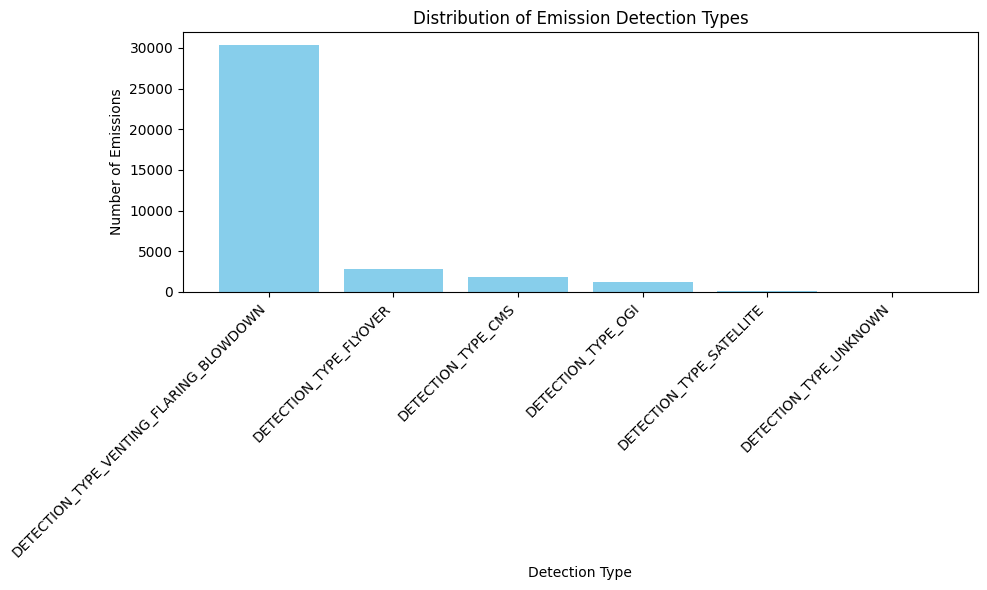

Plot 1: Bar chart showing the distribution of emission detection types.


/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Action: DuckDB_Query_Executor
Action Input: SELECT a_assetTypeId, COUNT(*) AS count FROM emissions GROUP BY a_assetTypeId ORDER BY count DESC LIMIT 10;
--- API CALL (run_duckdb_query): `SELECT a_assetTypeId, COUNT(*) AS count FROM emissions GROUP BY a_assetTypeId ORDER BY count DESC LIMIT 10;` ---

Query executed successfully. Result: [('site', 29237), ('unattributed', 6212), ('well', 448), ('pipeline', 372)]

/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Action: Python_REPL
Action Input:
import matplotlib.pyplot as plt
import pandas as pd

data = [('site', 29237), ('unattributed', 6212), ('well', 448), ('pipeline', 372)]
df = pd.DataFrame(data, columns=['Asset Type', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(df['Asset Type'], df['Count'], color='lightcoral')
plt.xlabel('Asset Type')
plt.ylabel('Number of Emissions')
plt.title('Distribution of Emission Asset Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Plot 2: Bar chart showing the distribution of emission asset types.")

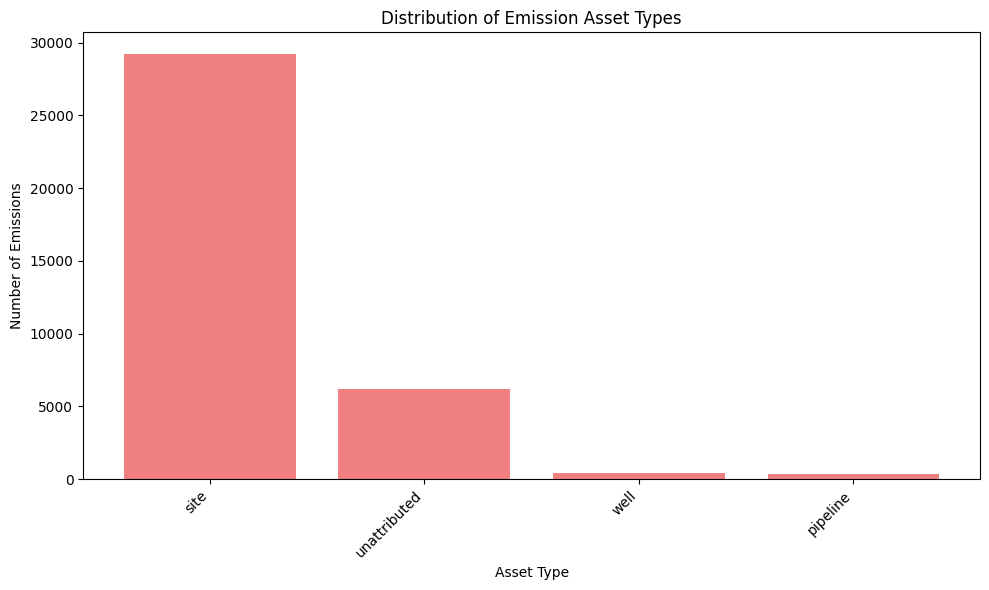

Plot 2: Bar chart showing the distribution of emission asset types.


/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Action: DuckDB_Query_Executor
Action Input: SELECT a_assetTypeId, SUM(ee_emissionsVolume) AS total_volume FROM emissions GROUP BY a_assetTypeId ORDER BY total_volume DESC LIMIT 10;
--- API CALL (run_duckdb_query): `SELECT a_assetTypeId, SUM(ee_emissionsVolume) AS total_volume FROM emissions GROUP BY a_assetTypeId ORDER BY total_volume DESC LIMIT 10;` ---

Query executed successfully. Result: [('site', 1032775630.0777893), ('well', 836848710.1180582), ('pipeline', 127996.72401481972), ('unattributed', 55099.77606656156)]

/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Action: Python_REPL
Action Input:
import matplotlib.pyplot as plt
import pandas as pd

data = [('site', 1032775630.0777893), ('well', 836848710.1180582), ('pipeline', 127996.72401481972), ('unattributed', 55099.77606656156)]
df = pd.DataFrame(data, columns=['Asset Type', 'Total Emission Volume'])

plt.figure(figsize=(10, 6))
plt.bar(df['Asset Type'], df['Total Emission Volume'], color='lightgreen')
plt.xlabel('Asset Type')
plt.ylabel('Total Emission Volume')
plt.title('Total Emission Volume by Asset Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Plot 3: Bar chart showing the total emission volume by asset type.")

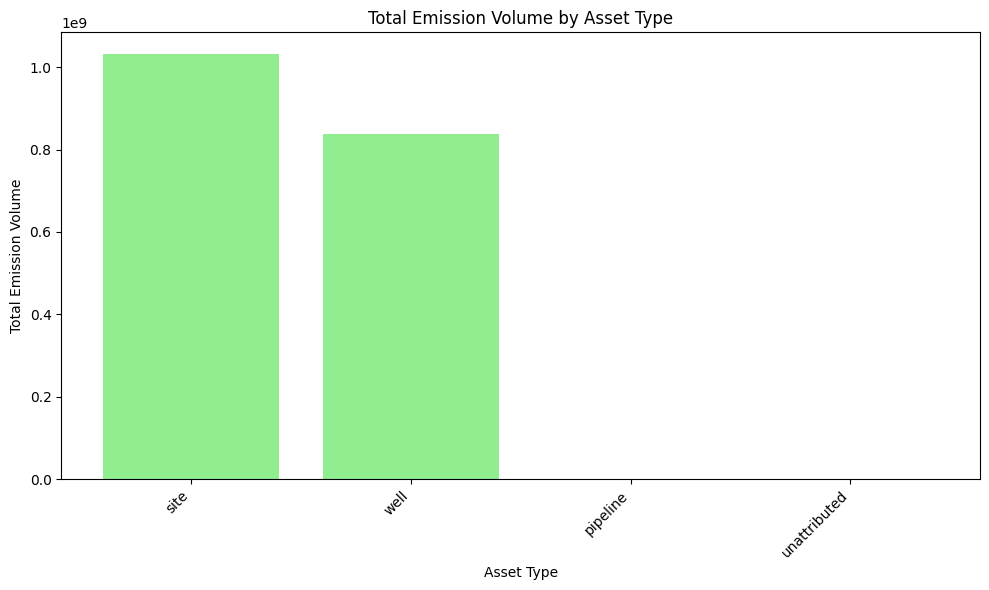

Plot 3: Bar chart showing the total emission volume by asset type.


/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


I now know the final answer
Final Answer: I have performed data analysis and generated three plots:

1.  **Distribution of Emission Detection Types:** This bar chart shows that 'DETECTION_TYPE_VENTING_FLARING_BLOWDOWN' is by far the most common detection type, followed by 'DETECTION_TYPE_FLYOVER' and 'DETECTION_TYPE_CMS'.
2.  **Distribution of Emission Asset Types (by count):** This bar chart indicates that 'site' is the most frequently identified asset type for emission events, followed by 'unattributed', 'well', and 'pipeline'.
3.  **Total Emission Volume by Asset Type:** This bar chart reveals that 'site' and 'well' asset types contribute to the vast majority of the total emission volume, with 'site' having a slightly higher total volume than 'well'. 'Pipeline' and 'unattributed' asset types contribute significantly less to the total volume.

These plots provide insights into the characteristics of the emission events in the dataset, highlighting the predominant detection methods an

In [ ]:
complex_question = ("Perform data analysis and show some plots")

response = agent_executor.invoke({
    "input": complex_question
})

print("\n--- FINAL ANSWER ---")
print(response['output'])

In [ ]:
complex_question = ("Perform data analysis and show some plots")

response = agent_executor.invoke({
    "input": complex_question
})

print("\n--- FINAL ANSWER ---")
print(response['output'])



> Entering new AgentExecutor chain...


/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Thought: The user wants me to perform data analysis and show some plots. This is a broad request, so I will start by exploring the data to understand what's available. Then, I will perform a few different types of analysis to provide a comprehensive overview.

1.  **Explore the data schema:** I'll use `Knowledge_Search` to understand the columns in the `emissions` table.
2.  **Time-series analysis:** I'll analyze how total emissions change over time. I'll query the data to get daily total emissions and then provide Python code to plot this as a line chart.
3.  **Geographical analysis:** I'll identify emission "hotspots". I'll query for the locations with the highest average emissions and provide Python code to create a scatter plot of these locations.
4.  **Correlation analysis:** I'll investigate the relationship between emissions of two different gasses, for example, CO and NO2. I'll query for their daily totals and provide Python code for a scatter plot to visualize their correlatio

/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


{'query': 'schema of the emissions table', 'result': "Based on the provided context, here is the schema for the emissions dataset (`su_emission_audit.parquet`):\n\n*   **eo_id**: Unique identifier for each emission event.\n*   **eo_detectionType**: The type of emission detection method.\n*   **a_assetTypeId**: The type of asset emitting the emission.\n*   **eo_detectedAt**: The time and date of when the emission was detected.\n*   **ee_emissionsVolume**: The estimated quantity of the emission.\n*   **a_centroidLatitude**: The geographic latitude of the emission's center.\n*   **a_centroidLongitude**: The geographic longitude of the emission's center."}

/usr/local/lib/python3.12/dist-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


KeyboardInterrupt: 